<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [30]:
# Set your student number
student_number = 400100962
Name = 'Parsa'
Last_Name = 'Hatami'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [31]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [32]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [57]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [58]:
## FILL HERE
num_classes = len(train_set.classes)
input_dim = train_set[0][0].shape[1] * train_set[0][0].shape[2]
print("classes number: ",num_classes)
print("first layer input dimention: ",input_dim)

classes number:  10
first layer input dimention:  784


In [59]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

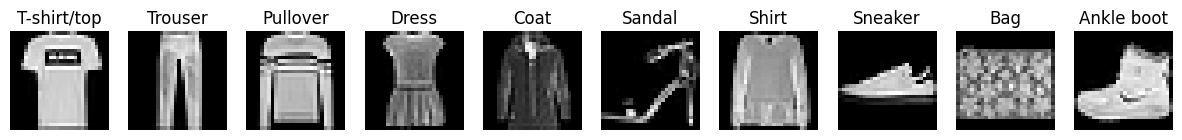

In [60]:
images_per_class = {class_name: None for class_name in train_set.classes}
for image, label in train_set:
    class_name = train_set.classes[label]
    if images_per_class[class_name] is None:
        images_per_class[class_name] = image
    if all(value is not None for value in images_per_class.values()):
        break

fig, axs = plt.subplots(1, len(images_per_class), figsize=(15, 15))
for ax, (class_name, image) in zip(axs, images_per_class.items()):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_name)
    ax.axis('off')

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [61]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [62]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [63]:
def affine_forward(x, w, b):
    ## FILL HERE
    return x @ w+b


def relu(x):
    ## FILL HERE
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [64]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    ## FILL HERE
    for i in range(num_layers):
        w=parameters[f'w{i}']
        b=parameters[f'b{i}']
        x=affine_forward(x,w,b)
        if i<num_layers-1:
            x=relu(x)
    output=x
    
    return output

Implementing cross entropy loss:

In [65]:
def cross_entropy_loss(scores, y):
    if scores.device != y.device:
        y = y.to(scores.device)

    max_scores = scores.max(dim=1, keepdim=True)[0]
    stabilized_scores = scores - max_scores
    exp_scores = stabilized_scores.exp()
    softmax_scores = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    n = y.size(0)
    log_probs = softmax_scores.log()
    selected_log_probs = log_probs[range(n), y]
    loss = -selected_log_probs.mean()
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [66]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    for name, param in parameters.items():
        if param.grad is not None:
            with torch.no_grad():
                param -= learning_rate * param.grad
                param.grad.zero_()

Training functions:

In [67]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct = (y_pred == y_true).sum()
    total = y_true.size
    acc = correct / total
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        
        train_loss += loss.item()
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Epoch: {epoch}, Batch: {i}, Train Loss: {train_loss / N_train}, Accuracy: {acc}')
    return train_loss / N_train, acc

def validate(loader, epoch=None, set_name=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Epoch: {epoch}, {set_name} Loss: {total_loss}, Accuracy: {acc}')

    return total_loss, acc

In [68]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [69]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, 'Test')
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # plot the loss history of training and test sets 
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Loss history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the accuracy history of training and test sets
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch: 0, Batch: 937, Train Loss: 0.03586138082345327, Accuracy: 0.22966666666666666
Epoch: 0, Test Loss: 0.035792687463760374, Accuracy: 0.2859
Epoch: 1, Batch: 937, Train Loss: 0.0343225465575854, Accuracy: 0.23518333333333333
Epoch: 1, Test Loss: 0.030256288003921508, Accuracy: 0.2074
Epoch: 2, Batch: 937, Train Loss: 0.022793119328220684, Accuracy: 0.42311666666666664
Epoch: 2, Test Loss: 0.01789569789171219, Accuracy: 0.5322
Epoch: 3, Batch: 937, Train Loss: 0.015866320370634398, Accuracy: 0.59215
Epoch: 3, Test Loss: 0.014830440014600753, Accuracy: 0.6296
Epoch: 4, Batch: 937, Train Loss: 0.013459374860922496, Accuracy: 0.67115
Epoch: 4, Test Loss: 0.013295854741334915, Accuracy: 0.6856
Epoch: 5, Batch: 937, Train Loss: 0.012212252721190453, Accuracy: 0.7132
Epoch: 5, Test Loss: 0.01185144863128662, Accuracy: 0.7276
Epoch: 6, Batch: 937, Train Loss: 0.011265126921236514, Accuracy: 0.7413333333333333
Epoch: 6, Test Loss: 0.012269282388687134, Accuracy: 0.7143
Epoch: 7, Batch: 937,

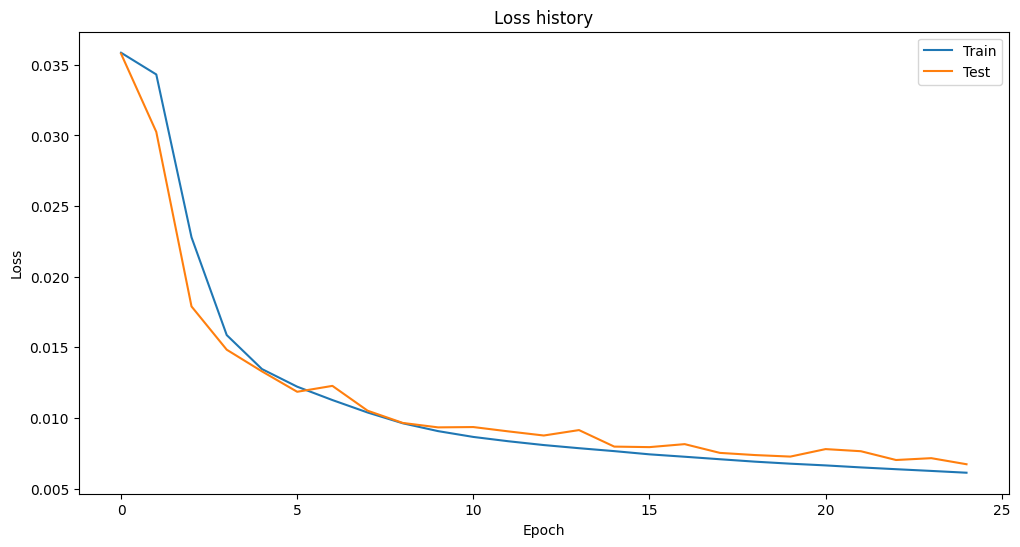

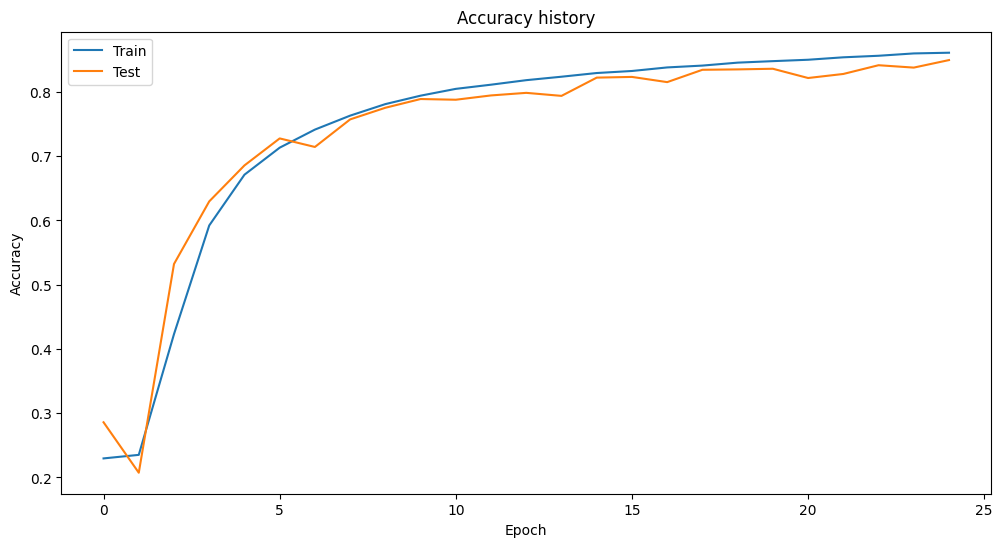

In [70]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [71]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8495


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

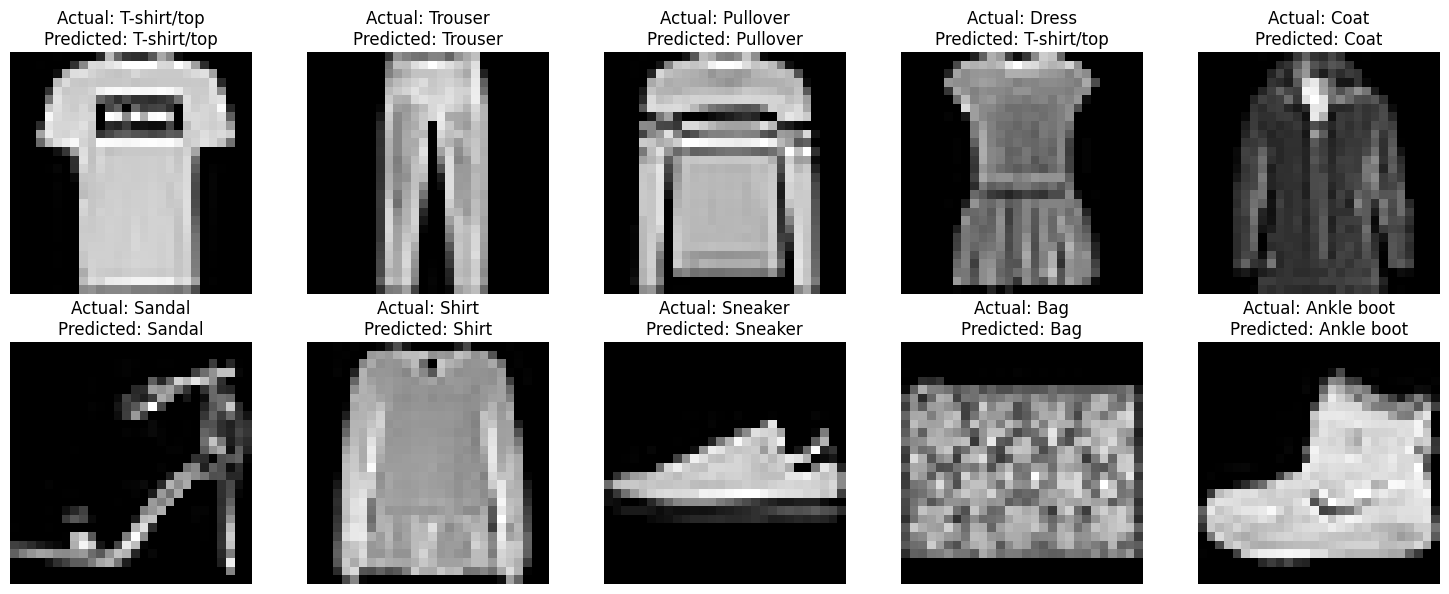

In [74]:
class_images_dict = dict.fromkeys(train_set.classes)

for img, lbl in train_set:
    class_lbl = train_set.classes[lbl]
    if class_images_dict[class_lbl] is None:
        class_images_dict[class_lbl] = (img, lbl)
    if None not in class_images_dict.values():
        break

tensor_images = torch.stack([img[0] for img in class_images_dict.values()])

with torch.no_grad():
    predictions = model(tensor_images.to(device), parameters)

predicted_lbls = torch.argmax(predictions, dim=1).cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for axis, ((img, actual_lbl), predicted_lbl) in zip(axes.flatten(), zip(class_images_dict.values(), predicted_lbls)):
    class_lbl = train_set.classes[actual_lbl]
    predicted_class_lbl = test_set.classes[predicted_lbl]
    axis.imshow(img.permute(1, 2, 0).cpu(), cmap='gray')
    axis.set_title(f"Actual: {class_lbl}\nPredicted: {predicted_class_lbl}")
    axis.axis('off')

plt.tight_layout()
plt.show()